In [1]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import string
from typing import List
import data
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.set_option('display.max_rows', None)

2022-07-08 18:06:59.952910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 18:06:59.952947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/accounts/projects/vision/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Compute embeddings for sst2 using bert finetuned model.

In [32]:
class A:
    checkpoint = 'textattack/bert-base-uncased-SST-2'
    dataset = 'sst2'
    padding = True
args = A()

# data
dataset, args = data.process_data_and_args(args)

# countvectorizer
tok_simp = English().tokenizer
tokenizer_func = lambda x: [str(x) for x in tok_simp(x)] 
v = CountVectorizer(tokenizer=tokenizer_func)
v.fit(dataset['train']['sentence'])
words = sorted(list(v.vocabulary_.keys()))

"""Note that vocab is already based on words being sorted
remap_idxs = {
    i: v.vocabulary_[k] for i, k in enumerate(words)
}
for i in range(len(remap_idxs)):
    assert remap_idxs[i] == i
"""

# set up model
def get_embs(texts: List[str]):
    tokenizer = AutoTokenizer.from_pretrained(args.checkpoint) # for actually passing things to the model
    model = BertModel.from_pretrained(args.checkpoint)

    tokens = tokenizer(texts, padding=args.padding, truncation=True, return_tensors="pt")
    output = model(**tokens) # this takes a while....
    embs = output['pooler_output'].cpu().detach().numpy()
    return embs

Using custom data configuration default
Reusing dataset sst2 (/tmp/.xdg_cache_vision/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

/accounts/projects/vision/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


# look at unigrams

In [ ]:
embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))

# countvec coefs
matrix = v.transform(dataset['train']['sentence'])
tot_counts = pd.DataFrame(matrix.sum(axis=0), columns=v.get_feature_names())
m = LogisticRegressionCV()
m.fit(matrix, dataset['train']['label'])
coef = m.coef_.flatten() # note -- coef has not been mapped to same idxs as words

# make df
df = pd.DataFrame.from_dict({
    'coef': coef,
    'tot_counts': tot_counts.values.squeeze(),
    'unigram': words,
})
# df.to_csv(oj(config.misc_dir, 'df_unigram_sst.csv'))

In [3]:
df = pd.read_csv(oj(config.misc_dir, 'df_unigram_sst.csv'), index_col=0)

### compute unigram embeddings

In [39]:
embs = get_embs(words)
pkl.dump(embs, open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'wb'))
pkl.dump(words, open(oj(config.misc_dir, 'word_list_sst_train.pkl'), 'wb'))

In [274]:
def get_idxs(unigrams, tot_counts, coef, percentile=99.5):
    idxs_punc = np.array(list(map(lambda s: all(c.isdigit() or c in string.punctuation for c in s),
                  unigrams)))
    idxs_count_large = tot_counts > np.percentile(tot_counts, percentile)

    cs = np.abs(coef).flatten()
    idxs_pred = cs >= np.percentile(cs, percentile)

    idxs = (idxs_pred | idxs_count_large) & ~is_punc
    return idxs


idxs = get_idxs(df['unigram'], df['tot_counts'].values, df['coef'].values, percentile=99.5)
es = pd.DataFrame(embs[idxs].T, columns=df['unigram'].values[idxs])
sims = es.corr()

In [ ]:
# def coef_colors(coef):
#     if coef >= 0:
#         return 'green'
#     else:
#         return 'purple'

plt.figure(figsize=(12, 12))
vabs = np.max(np.abs(sims))
cm = sns.diverging_palette(10, 240, as_cmap=True)
cg = sns.clustermap(sims, cmap=cm, center=0.0, dendrogram_ratio=0.01,
                    cbar_pos=(0.7, 0.7, 0.05, 0.15),
                    cbar_kws={'label': 'Correlation'},
#                     row_colors=list(map(coef_colors, coef[idxs])),
#                     row_colors=list(map(cm, m.coef_.flatten()[idxs])),                    
#                     row_colors=list(map(cm, np.log(tot_counts[idxs]) / max(np.log(tot_counts[idxs])))),                      
#                     yticklabels=3 # how often to plot yticklabels
)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

# mask
mask = np.triu(np.ones_like(sims))
values = cg.ax_heatmap.collections[0].get_array().reshape(sims.shape)
new_values = np.ma.array(values, mask=mask)
cg.ax_heatmap.collections[0].set_array(new_values)
cg.ax_heatmap.yaxis.set_ticks_position("left")


xaxis = cg.ax_heatmap.get_xaxis()
xticklabels = xaxis.get_majorticklabels()
# plt.tight_layout()
cg.savefig('results/unigrams_sim.pdf')
# plt.tight_layout()

# bigram analysis

Here we will compare coefs of common bigrams to the sum of the coefs of their unigrams

**get bigram coefs**

In [ ]:
v2 = CountVectorizer(tokenizer=tokenizer_func, ngram_range=(2, 2))
v2.fit(dataset['train']['sentence'])

In [ ]:
# countvec coefs
matrix2 = v2.transform(dataset['train']['sentence'])
tot_counts2 = pd.DataFrame(matrix2.sum(axis=0), columns=v2.get_feature_names())
m2 = LogisticRegressionCV()
m2.fit(matrix2, dataset['train']['label'])
coef2 = m2.coef_.flatten() # note -- coef has not been mapped to same idxs as words

df2 = pd.DataFrame.from_dict({
    'coef': coef2,
    'tot_counts': tot_counts2.values.squeeze(),
#     'unigram': words,
    'bigram': sorted(list(v2.vocabulary_.keys()))
})

In [330]:
def find_unigram_scores(bigram):
    unigram1, unigram2 = bigram.split(' ')
    unigram1_score = df.loc[df['unigram'] == unigram1, 'coef'].iloc[0]
    unigram2_score = df.loc[df['unigram'] == unigram2, 'coef'].iloc[0]
    return unigram1, unigram2, unigram1_score, unigram2_score

out = list(zip(*df2['bigram'].map(find_unigram_scores)))
for (i, c) in enumerate(['unigram1', 'unigram2', 'coef1', 'coef2']):
    df2[c] = out[i]


**get bigram embeddings**

In [53]:
df2 = pd.read_csv(oj(config.misc_dir, 'df_bigram_sst.csv'), index_col=0)
df2['interaction_score'] = abs(df2['coef'] - (df2['coef1'] + df2['coef2']))
df2 = df2[['bigram', 'interaction_score', 'tot_counts', # reordering
           'coef', 'coef1', 'coef2', 'unigram1', 'unigram2', ]]
# df2.to_csv(oj(config.misc_dir, 'df_bigram_sst.csv'))

**here we can just see which bigrams interact the most** 
(Nothing to do with embeddings yet)

In [80]:
d = df2.sort_values('interaction_score', ascending=False).round(2)
d = d[d.tot_counts > 2]
d = d.head(200)

In [85]:
bigrams = d['bigram'].values.tolist()
embs2 = get_embs(bigrams)

pkl.dump(embs2, open(oj(config.misc_dir, 'embs2_sst_top_interactions.pkl'), 'wb'))
pkl.dump(bigrams, open(oj(config.misc_dir, 'word_list_sst_top_interactions.pkl'), 'wb'))
pkl.dump(d, open(oj(config.misc_dir, 'top_interacting_words_df2.pkl'), 'wb'))

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# let's compare bert coefs

In [86]:
df = pd.read_csv(oj(config.misc_dir, 'df_unigram_sst.csv'), index_col=0)
df2 = pd.read_csv(oj(config.misc_dir, 'df_bigram_sst.csv'), index_col=0)
d = pkl.load(open(oj(config.misc_dir, 'top_interacting_words_df2.pkl'), 'rb'))

embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))
embs2 = pkl.load(open(oj(config.misc_dir, 'embs2_sst_top_interactions.pkl'), 'rb'))

In [87]:
r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'],
                             dset_filters=['sst2'],
                             drop_model=False)
row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]
logistic = row.model
coef_bert = logistic.coef_.squeeze()

100%|██████████| 14/14 [00:00<00:00, 1057.18it/s]


In [88]:
d['bert_coef_bigram'] = embs2 @ coef_bert
df['bert_coef_unigram'] = embs @ coef_bert # used for looking-up

def find_unigram_scores(unigram):
    return df.loc[df['unigram'] == unigram, 'bert_coef_unigram'].iloc[0]
d['bert_coef_unigram1'] = d['unigram1'].apply(find_unigram_scores)
d['bert_coef_unigram2'] = d['unigram2'].apply(find_unigram_scores)

In [89]:
d.head()

,bigram,interaction_score,tot_counts,coef,coef1,coef2,unigram1,unigram2,bert_coef_bigram,bert_coef_unigram1,bert_coef_unigram2
44950,not bad,13.25,7,6.44,-3.19,-3.62,not,bad,0.347631,-0.351654,-0.801170
57713,spielberg calls,13.05,7,0.08,3.82,9.31,spielberg,calls,-0.192839,0.358623,-0.767201
43880,n't lost,13.02,14,4.86,-3.63,-4.53,n't,lost,0.506353,-0.400545,-0.896784
44408,never lacks,12.72,4,4.27,-1.10,-7.36,never,lacks,0.790974,-0.315804,-1.295606
34889,incoherent mess,12.48,3,-0.56,-3.90,-9.14,incoherent,mess,-1.099683,-0.856689,-1.124526


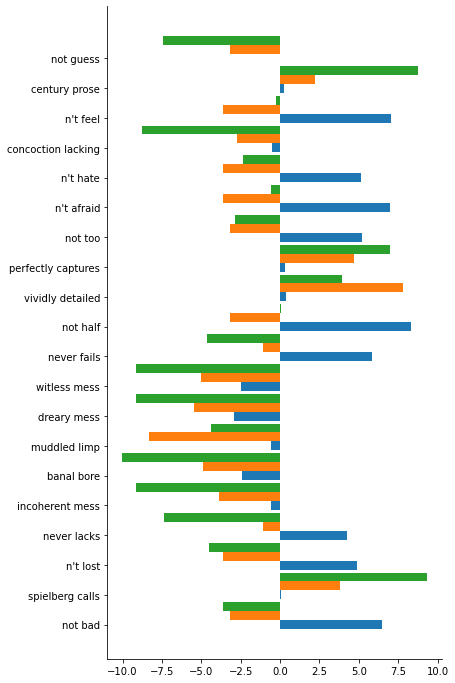

In [104]:
plt.figure(figsize=(6, 12))
idxs = np.arange(20)
dp = d.iloc[idxs]
plt.barh(idxs, dp['coef'], height=0.3)
plt.barh(idxs + 0.3, dp['coef1'], height=0.3)
plt.barh(idxs + 0.6, dp['coef2'], height=0.3)
plt.yticks(idxs, dp['bigram'])
plt.show()

**bert coefs are similar to bigram coefs**

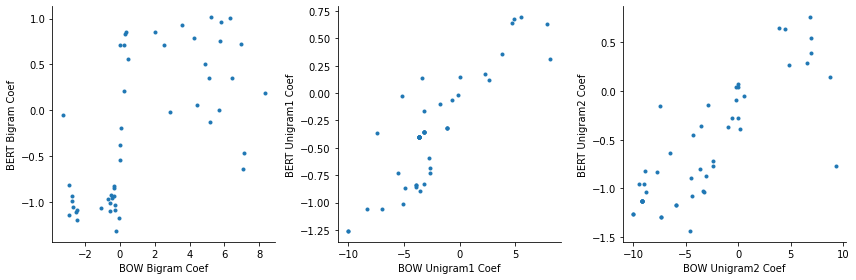

In [108]:
R, C = 1, 3
# fig, axes = plt.subplots(R, C)
# .lmplot(x='coef', y='bert_coef_bigram', data=d, ax=axes[0])
plt.figure(figsize=(12, 4))
plt.subplot(R, C, 1)
plt.plot(d['coef'], d['bert_coef_bigram'], '.')
plt.xlabel('BOW Bigram Coef')
plt.ylabel('BERT Bigram Coef')

plt.subplot(R, C, 2)
plt.plot(d['coef1'], d['bert_coef_unigram1'], '.')
plt.xlabel('BOW Unigram1 Coef')
plt.ylabel('BERT Unigram1 Coef')

plt.subplot(R, C, 3)
plt.plot(d['coef2'], d['bert_coef_unigram2'], '.')
plt.xlabel('BOW Unigram2 Coef')
plt.ylabel('BERT Unigram2 Coef')
plt.tight_layout()
plt.savefig('results/bert_bow_coef_compare.pdf')
plt.show()

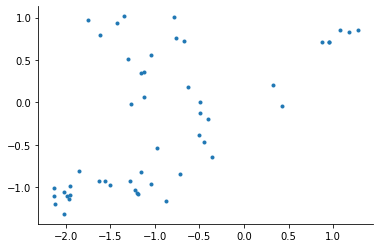

In [91]:
plt.plot(d['bert_coef_unigram1'] + d['bert_coef_unigram2'], d['bert_coef_bigram'], '.')